In [1]:
# !pip install tensorflow

### Import required Libraries:::::::

In [2]:
#import librabries
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from datetime import datetime
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

### EDA and Data Cleaning::::

In [3]:
risk_purchase_data = pd.read_csv('/content/risk-dataset.txt', delimiter="\t")

In [4]:
risk_purchase_data.head()

,ORDER_ID,CLASS,B_EMAIL,B_TELEFON,B_BIRTHDATE,FLAG_LRIDENTISCH,FLAG_NEWSLETTER,Z_METHODE,Z_CARD_ART,Z_CARD_VALID,...,FAIL_RPLZ,FAIL_RORT,FAIL_RPLZORTMATCH,SESSION_TIME,NEUKUNDE,AMOUNT_ORDER_PRE,VALUE_ORDER_PRE,DATE_LORDER,MAHN_AKT,MAHN_HOECHST
0,49917,no,yes,no,1/17/1973,yes,yes,check,?,5.2006,...,no,no,no,8,yes,0,0.00,?,?,?
1,49919,no,yes,yes,12/8/1970,no,no,credit_card,Visa,12.2007,...,yes,no,no,13,yes,0,0.00,?,?,?
2,49923,no,yes,no,4/3/1972,yes,no,check,?,12.2007,...,no,no,no,3,yes,0,0.00,?,?,?
3,49924,no,no,yes,8/1/1966,yes,no,check,?,1.2007,...,no,no,no,11,no,4,75.72,5/12/2002,0,0
4,49927,no,yes,yes,12/21/1969,yes,no,credit_card,Eurocard,12.2006,...,no,no,no,16,yes,0,0.00,?,?,?


In [5]:
risk_purchase_data.columns

Index(['ORDER_ID', 'CLASS', 'B_EMAIL', 'B_TELEFON', 'B_BIRTHDATE',
       'FLAG_LRIDENTISCH', 'FLAG_NEWSLETTER', 'Z_METHODE', 'Z_CARD_ART',
       'Z_CARD_VALID', 'Z_LAST_NAME', 'VALUE_ORDER', 'WEEKDAY_ORDER',
       'TIME_ORDER', 'AMOUNT_ORDER', 'ANUMMER_01', 'ANUMMER_02', 'ANUMMER_03',
       'ANUMMER_04', 'ANUMMER_05', 'ANUMMER_06', 'ANUMMER_07', 'ANUMMER_08',
       'ANUMMER_09', 'ANUMMER_10', 'CHK_LADR', 'CHK_RADR', 'CHK_KTO',
       'CHK_CARD', 'CHK_COOKIE', 'CHK_IP', 'FAIL_LPLZ', 'FAIL_LORT',
       'FAIL_LPLZORTMATCH', 'FAIL_RPLZ', 'FAIL_RORT', 'FAIL_RPLZORTMATCH',
       'SESSION_TIME', 'NEUKUNDE', 'AMOUNT_ORDER_PRE', 'VALUE_ORDER_PRE',
       'DATE_LORDER', 'MAHN_AKT', 'MAHN_HOECHST'],
      dtype='object')

In [6]:
risk_purchase_data.shape

(30000, 44)

In [7]:
risk_purchase_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 44 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ORDER_ID           30000 non-null  int64  
 1   CLASS              30000 non-null  object 
 2   B_EMAIL            30000 non-null  object 
 3   B_TELEFON          30000 non-null  object 
 4   B_BIRTHDATE        30000 non-null  object 
 5   FLAG_LRIDENTISCH   30000 non-null  object 
 6   FLAG_NEWSLETTER    30000 non-null  object 
 7   Z_METHODE          30000 non-null  object 
 8   Z_CARD_ART         30000 non-null  object 
 9   Z_CARD_VALID       30000 non-null  float64
 10  Z_LAST_NAME        30000 non-null  object 
 11  VALUE_ORDER        30000 non-null  float64
 12  WEEKDAY_ORDER      30000 non-null  object 
 13  TIME_ORDER         30000 non-null  object 
 14  AMOUNT_ORDER       30000 non-null  int64  
 15  ANUMMER_01         30000 non-null  int64  
 16  ANUMMER_02         300

### Changing data inconsistent datatypes::::

In [8]:
columns_to_convert = ['ANUMMER_02', 'ANUMMER_03', 'ANUMMER_04', 'ANUMMER_05', 'ANUMMER_06',
                      'ANUMMER_07', 'ANUMMER_08', 'ANUMMER_09', 'ANUMMER_10','MAHN_AKT','MAHN_HOECHST']
for col in columns_to_convert:
  risk_purchase_data[col] = pd.to_numeric(risk_purchase_data[col], errors='coerce')

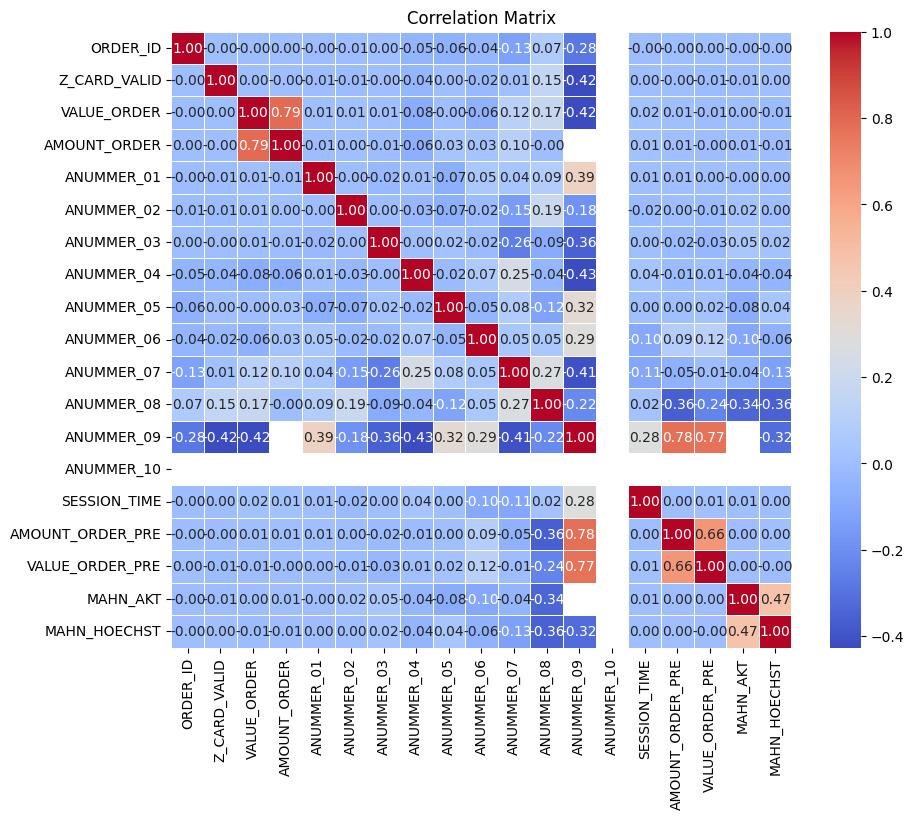

In [9]:
numerical_columns = risk_purchase_data.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numerical_columns.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In the above correlation matrix, we can see that the amout_order_pre and value_order_pre are highly correlation nearly 80 which is also correlated to ANUMBER_09.so we can remove two of these feature.

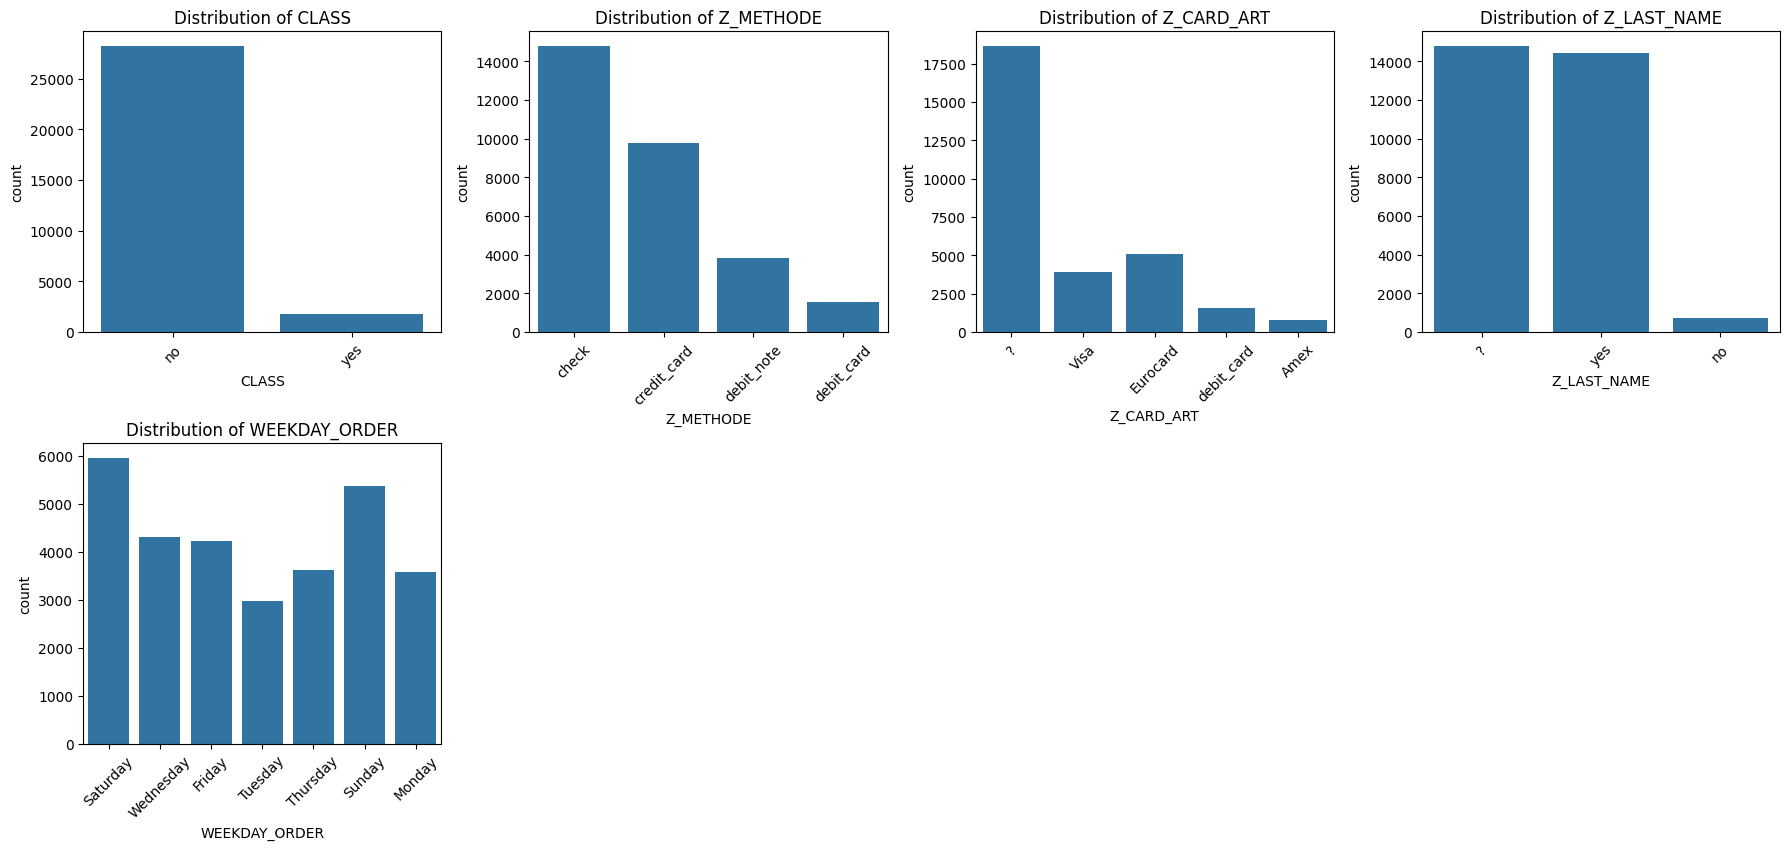

In [10]:
categorical_cols = ['CLASS','Z_METHODE', 'Z_CARD_ART', 'Z_LAST_NAME', 'WEEKDAY_ORDER' ]

plt.figure(figsize=(18, 20))

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(5, 4, i)
    sns.countplot(data=risk_purchase_data, x=col)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.show()

The bar plot shows the distribution of the categories present in the dataset. Rather than yes/no,I have checked other features distribution.

### Replacing '?' with the null values:::::

In [11]:
risk_purchase_data.replace('?', np.nan, inplace=True)

In [12]:
risk_purchase_data.isnull().sum()


,0
ORDER_ID,0
CLASS,0
B_EMAIL,0
B_TELEFON,0
B_BIRTHDATE,2942
FLAG_LRIDENTISCH,0
FLAG_NEWSLETTER,0
Z_METHODE,0
Z_CARD_ART,18654
Z_CARD_VALID,0


### Handling Missing Data, Feature Engineering and Pre-processing:::::

#### Extracting age from date of birth:::::

In [13]:
def calculate_age(birthdate):
    if pd.isnull(birthdate):
        return 0
    today = datetime.today()
    return today.year - birthdate.year - ((today.month, today.day) < (birthdate.month, birthdate.day))

risk_purchase_data['B_BIRTHDATE'] = pd.to_datetime(risk_purchase_data['B_BIRTHDATE'], errors='coerce')

risk_purchase_data['Age'] = risk_purchase_data['B_BIRTHDATE'].apply(calculate_age)

#### Replacing null values for receipt number and remainders values to 0::::

In [14]:
columns_to_fill_zero = ['ANUMMER_01', 'ANUMMER_02', 'ANUMMER_03', 'ANUMMER_04',
                   'ANUMMER_05', 'ANUMMER_06', 'ANUMMER_07', 'ANUMMER_08',
                   'ANUMMER_09', 'ANUMMER_10','MAHN_AKT','MAHN_HOECHST']

risk_purchase_data[columns_to_fill_zero] = risk_purchase_data[columns_to_fill_zero].fillna(0)

#### Extracting category of purchase gap from last order date:::::

In [15]:
risk_purchase_data['DATE_LORDER'] = pd.to_datetime(risk_purchase_data['DATE_LORDER'], errors='coerce')

current_date = datetime.today()

risk_purchase_data['days_since_last_order'] = risk_purchase_data['DATE_LORDER'].apply(
    lambda x: (current_date - x).days if pd.notna(x) else np.nan
)

In [16]:
risk_purchase_data['days_since_last_order'].describe()

,days_since_last_order
count,14144.000000
mean,8119.665936
std,435.065889
min,7369.000000
25%,7741.000000
50%,8115.000000
75%,8499.000000
max,8868.000000


In [17]:
risk_purchase_data['Recency_Category'] = pd.cut(risk_purchase_data['days_since_last_order'],
                                                bins=[7000, 7500, 8000, 8500, 9000, float('inf')],
                                                labels=['New', 'Active', 'Lapsed', 'Churned', 'Long Gone'])
risk_purchase_data['Recency_Category'] = risk_purchase_data['Recency_Category'].cat.add_categories('Unknown')

#### Replacing some category with unknown category:::::

In [18]:
columns_to_fill_unknown = ['Z_CARD_ART','Z_METHODE', 'Z_LAST_NAME','TIME_ORDER', 'Recency_Category' ]
risk_purchase_data[columns_to_fill_unknown] = risk_purchase_data[columns_to_fill_unknown].fillna('Unknown')

#### New feature extraction from Time order to categories::::

In [19]:
unknown_count = risk_purchase_data[risk_purchase_data['TIME_ORDER'] == 'Unknown'].shape[0]
print(unknown_count)


20


In [20]:
risk_purchase_data['TIME_ORDER'] = risk_purchase_data['TIME_ORDER'].apply(lambda x: pd.to_datetime(x, format='%H:%M').time() if x != 'Unknown' else x)

def categorize_time_order(time):
    if time:
        return 'Unknown'
    if time >= pd.to_datetime('00:00:00', format='%H:%M').time() and time < pd.to_datetime('06:00:00', format='%H:%M').time():
        return 'Early Morning'
    elif time >= pd.to_datetime('06:00:00', format='%H:%M').time() and time < pd.to_datetime('12:00:00', format='%H:%M').time():
        return 'Morning'
    elif time >= pd.to_datetime('12:00:00', format='%H:%M').time() and time < pd.to_datetime('17:00:00', format='%H:%M').time():
        return 'Afternoon'
    elif time >= pd.to_datetime('17:00:00', format='%H:%M').time() and time < pd.to_datetime('22:00:00', format='%H:%M').time():
        return 'Evening'
    else:
        return 'Late Night'


risk_purchase_data['Time_Order_Category'] = risk_purchase_data['TIME_ORDER'].apply(categorize_time_order)

In [21]:
risk_purchase_data['Time_Order_Category'].unique()

array(['Unknown'], dtype=object)

In [22]:
risk_purchase_data['Z_CARD_VALID'].unique()

array([ 5.2006, 12.2007,  1.2007, 12.2006,  2.2007, 11.2007,  5.2005,
        9.2007, 11.2006,  2.2006,  6.2006,  3.2007,  6.2005,  6.2007,
        3.2005,  4.2005, 11.2005,  4.2006,  3.2006,  9.2006, 12.2005,
        8.2007, 10.2006,  2.2005,  7.2007, 10.2005,  7.2005,  8.2005,
        9.2005,  7.2006,  1.2006,  1.2005,  8.2006, 10.2007,  4.2007,
        5.2007])

#### Transforming the card validity to expired or not expired category::::

In [23]:
risk_purchase_data['Z_CARD_VALID'] = pd.to_datetime(risk_purchase_data['Z_CARD_VALID'], format='%m.%Y', errors='coerce')
current_date = pd.to_datetime('today')
risk_purchase_data['Z_CARD_VALID'] = (risk_purchase_data['Z_CARD_VALID'] < current_date).astype(int)

#### Changing the category yes/no to numerical:::::

In [24]:
yes_no_cols = ['B_EMAIL', 'B_TELEFON', 'FLAG_LRIDENTISCH', 'FLAG_NEWSLETTER', 'CHK_LADR',
               'CHK_RADR', 'CHK_KTO', 'CHK_CARD', 'CHK_COOKIE', 'CHK_IP', 'FAIL_LPLZ',
               'FAIL_LORT', 'FAIL_LPLZORTMATCH', 'FAIL_RPLZ', 'FAIL_RORT', 'FAIL_RPLZORTMATCH', 'NEUKUNDE']
for col in yes_no_cols:
    risk_purchase_data[col] = risk_purchase_data[col].map({'yes': 1, 'no': 0})

#### Dropping unwanted columns::::

In [25]:
risk_purchase_data.drop(['ORDER_ID','B_BIRTHDATE','DATE_LORDER','days_since_last_order','TIME_ORDER','ANUMMER_10','ANUMMER_09'], axis=1, inplace=True)

#### Validating the handling of missing data::::

In [26]:
risk_purchase_data.isnull().sum()

,0
CLASS,0
B_EMAIL,0
B_TELEFON,0
FLAG_LRIDENTISCH,0
FLAG_NEWSLETTER,0
Z_METHODE,0
Z_CARD_ART,0
Z_CARD_VALID,0
Z_LAST_NAME,0
VALUE_ORDER,0


### Data

In [27]:
X = risk_purchase_data.drop(columns=["CLASS"])
y = risk_purchase_data["CLASS"]

In [28]:
y = LabelEncoder().fit_transform(y)

In [29]:
X['WEEKDAY_ORDER'] = LabelEncoder().fit_transform(X['WEEKDAY_ORDER'])

In [30]:
object_category_columns = X.select_dtypes(include=['object', 'category']).columns
X = pd.get_dummies(X, columns=object_category_columns, drop_first=True).astype(int)

In [31]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 49 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   B_EMAIL                     30000 non-null  int64
 1   B_TELEFON                   30000 non-null  int64
 2   FLAG_LRIDENTISCH            30000 non-null  int64
 3   FLAG_NEWSLETTER             30000 non-null  int64
 4   Z_CARD_VALID                30000 non-null  int64
 5   VALUE_ORDER                 30000 non-null  int64
 6   WEEKDAY_ORDER               30000 non-null  int64
 7   AMOUNT_ORDER                30000 non-null  int64
 8   ANUMMER_01                  30000 non-null  int64
 9   ANUMMER_02                  30000 non-null  int64
 10  ANUMMER_03                  30000 non-null  int64
 11  ANUMMER_04                  30000 non-null  int64
 12  ANUMMER_05                  30000 non-null  int64
 13  ANUMMER_06                  30000 non-null  int64
 14  ANUMME

In [32]:
X.head()

,B_EMAIL,B_TELEFON,FLAG_LRIDENTISCH,FLAG_NEWSLETTER,Z_CARD_VALID,VALUE_ORDER,WEEKDAY_ORDER,AMOUNT_ORDER,ANUMMER_01,ANUMMER_02,...,Z_CARD_ART_Unknown,Z_CARD_ART_Visa,Z_CARD_ART_debit_card,Z_LAST_NAME_no,Z_LAST_NAME_yes,Recency_Category_Active,Recency_Category_Lapsed,Recency_Category_Churned,Recency_Category_Long Gone,Recency_Category_Unknown
0,1,0,1,1,0,17,2,1,406811,0,...,1,0,0,0,0,0,0,0,0,1
1,1,1,0,0,0,18,6,1,600953,0,...,0,1,0,0,1,0,0,0,0,1
2,1,0,1,0,0,10,0,1,406310,0,...,1,0,0,0,0,0,0,0,0,1
3,0,1,1,0,0,54,0,1,307359,0,...,1,0,0,0,0,0,1,0,0,0
4,1,1,1,0,0,19,5,1,200767,0,...,0,0,0,0,1,0,0,0,0,1


In [33]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [35]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [36]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weight_dict)

Class Weights: {0: np.float64(1.0), 1: np.float64(1.0)}


### Trainng and Evaluating the model:::::

In [37]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [38]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [39]:
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [40]:
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test), class_weight=class_weight_dict)

Epoch 1/25
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6570 - loss: 0.6305 - val_accuracy: 0.6960 - val_loss: 0.5665
Epoch 2/25
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7197 - loss: 0.5518 - val_accuracy: 0.7160 - val_loss: 0.5452
Epoch 3/25
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7399 - loss: 0.5231 - val_accuracy: 0.6965 - val_loss: 0.5666
Epoch 4/25
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7513 - loss: 0.5106 - val_accuracy: 0.7053 - val_loss: 0.5414
Epoch 5/25
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7626 - loss: 0.4888 - val_accuracy: 0.7243 - val_loss: 0.5015
Epoch 6/25
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7738 - loss: 0.4733 - val_accuracy: 0.7238 - val_loss: 0.5125
Epoch 7/25
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7786 - loss: 0.4660 - val_accuracy: 0.7370 - val_loss: 0.4868
Epoch 8/25
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7862 - loss: 0.4532 - 

In [41]:
loss, accuracy = model.evaluate(X_train, y_train)
print(f"Test Accuracy: {accuracy:.4f}")

1412/1412 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8390 - loss: 0.3226
Test Accuracy: 0.8724


In [42]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7772 - loss: 0.4552
Test Accuracy: 0.7835


### Visualiztion of the Result:::::

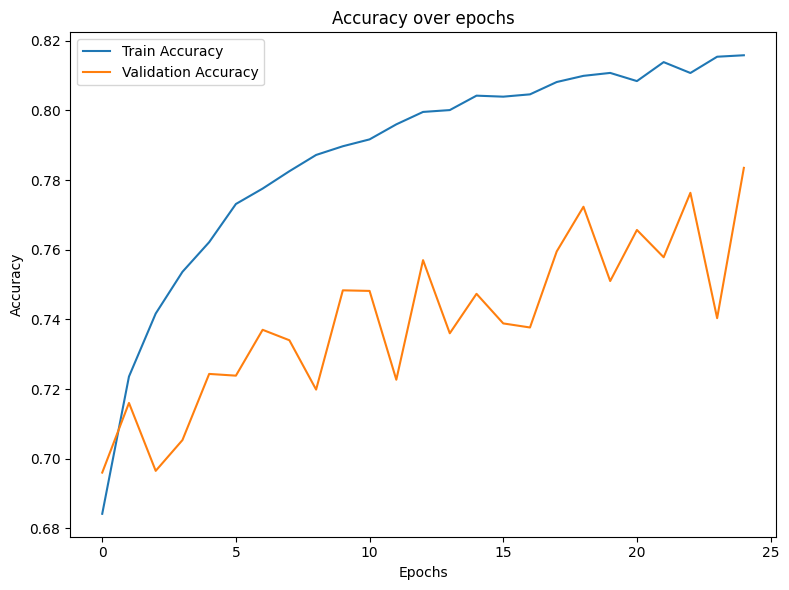

In [43]:
# Plot training & validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

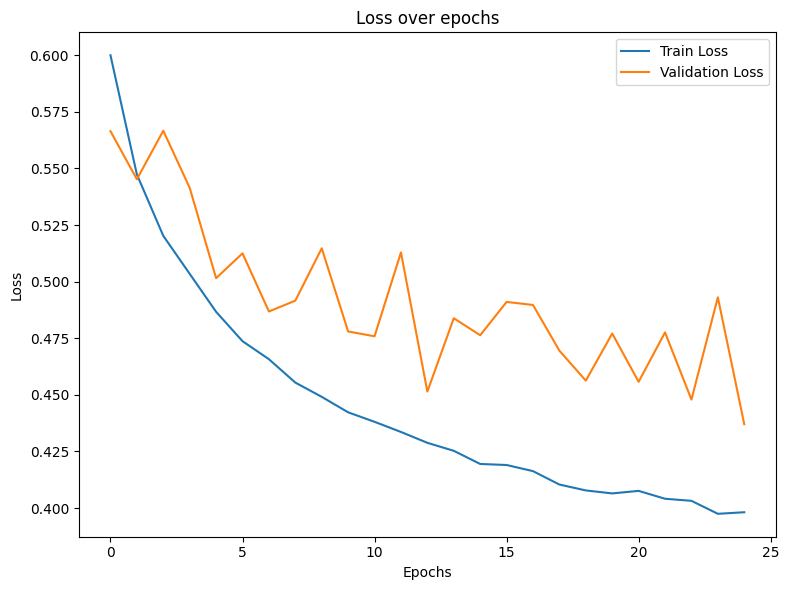

In [44]:
# Plot training & validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()